In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy import integrate
from scipy.special import iv
from tqdm import tqdm 
from functions import *

In [2]:
def n_f_dist(n_f,n_p):
    return np.linalg.norm((n_f-n_p))

In [3]:
def calc_dydt_controlled(y,df,K,k,k_p,k_i,g,s,lam,n_f,d):
    n = y[0:d]
    u_i = y[d]
    u_p = np.dot(s,n-n_f)
    dndt = np.matmul(k*(np.outer(np.ones(len(n)),n)+ K)**(-1),n) - lam*n - df*n - k_p*u_p - k_i*u_i
    duidt = np.dot(s,n-n_f)
    dydt = np.zeros(d+1)
    dydt[0:d] = dndt
    dydt[d] = duidt
    return dydt


In [4]:
def calc_dydt_controlled_multi_d(y,df,K,k,k_p,k_i,g,s,lam,n_f,d,l):
    n = y[0:d]
    u_i = y[d:l+d]
    u_p = np.matmul(s,n-n_f)
    dndt = np.matmul(k*(np.outer(np.ones(len(n)),n)+ K)**(-1),n) - lam*n - df*n - k_p*np.matmul(g,u_p) - k_i*np.matmul(g,u_i)
    duidt = np.matmul(s,n-n_f)
    dydt = np.zeros(d+l)
    dydt[0:d] = dndt
    dydt[d:l+d] = duidt
    return dydt


In [5]:
def sim_dyn_controlled(n_0,u_i_0,t_f,df,K,k,k_p,k_i,g,s,lam,n_f,d,l):
    def dydt(t,y):
        output = calc_dydt_controlled_multi_d(y,df,K,k,k_p,k_i,g,s,lam,n_f,d,l)
        return output
    t_span = [0, t_f]  # Time span to solve the differential equation
    rtol = 1e-6  # Relative tolerance for the solution
    atol = 1e-9  # Absolute tolerance for the solution
    y_0 = np.zeros(d+l)
    y_0[0:d] = n_0
    y_0[d:l+d] = u_i_0
    sol = solve_ivp(dydt, t_span, y_0, rtol=rtol, atol=atol, dense_output=True, method='Radau')

    # Create an interpolating function for the solution
    sol_fun = sol.sol

    # Evaluate the solution at a large number of time points for plotting
    t_eval = np.linspace(t_span[0], t_span[1], 1000)
    y_eval = sol_fun(t_eval)
    n_eval = y_eval[0:d,:]
    u_i_eval = y_eval[d:l+d,:]
    return n_eval, u_i_eval, t_eval

In [6]:
def evaluate_fitness_controlled_norm(K,k,k_p,k_i,g,s,lam,n_f,d,l,m,t_f):
    u_i_0 = np.zeros(l)
    n_0 = n_f
    dists = []
    for i in range(m):
        df = np.zeros(d) 
        df[i] = df[i]+2
        nt, u_i, t = sim_dyn_controlled(n_0,u_i_0,t_f,df,K,k,k_p,k_i,g,s,lam,n_f,d,l)
        dists.append(n_f_dist(n_f,nt[:,-1]))
    dists_norm = []
    for i in range(m):
        df = np.zeros(d) 
        df[i] = df[i]+2
        nt, u_i, t = sim_dyn_controlled(n_0,u_i_0,t_f,df,K,k,k_p,k_i,np.zeros(g.shape),np.zeros(s.shape),lam,n_f,d,l)
        dists_norm.append(n_f_dist(n_f,nt[:,-1]))
    return np.mean(dists)/np.mean(dists_norm)

In [9]:
ks = load_3d_matrix_from_csv("many_ks.csv")
Ks = load_3d_matrix_from_csv("many_KKs.csv")
d = Ks[0].shape[1]
lam = 5
lam = np.zeros(d)+lam
t_f = 2000

i = 0
k = ks[i]
K = Ks[i]
l = 1
#initialize fixed point
n_0 = np.zeros(d) + 0.5
n_eval, u_i_eval, t_eval = sim_dyn_controlled(n_0,np.zeros(l),t_f,np.zeros(d),K,k,0,0,np.zeros((d,l)),np.zeros((l,d)),lam,n_0,d,l)
n_f = n_eval[:,-1]

#find modes
J = calc_J(k,K,n_f,lam)
w_c, v = np.linalg.eig(J)
w = np.real(w_c)

current_dlambda = np.sort(w)[-2]/np.sort(w)[-1]

lambdas = []
is_connected = k != 0

In [10]:
np.sum(n_f)

1.2710203693480324

In [11]:
w[0]

-0.5662025178707295

In [12]:
np.dot(n_f/np.linalg.norm(n_f),v[:,0])

(0.9963761997952039+0j)

(array([6., 3., 5., 3., 4., 0., 5., 2., 1., 1.]),
 array([0.05278948, 0.08227881, 0.11176814, 0.14125746, 0.17074679,
        0.20023611, 0.22972544, 0.25921477, 0.28870409, 0.31819342,
        0.34768274]),
 <BarContainer object of 10 artists>)

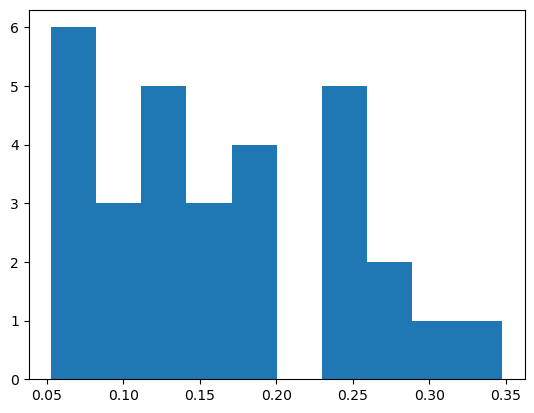

In [13]:
plt.hist(n_f/np.linalg.norm(n_f))

(array([6., 3., 5., 3., 4., 0., 5., 2., 1., 1.]),
 array([0.05278948, 0.08227881, 0.11176814, 0.14125746, 0.17074679,
        0.20023611, 0.22972544, 0.25921477, 0.28870409, 0.31819342,
        0.34768274]),
 <BarContainer object of 10 artists>)

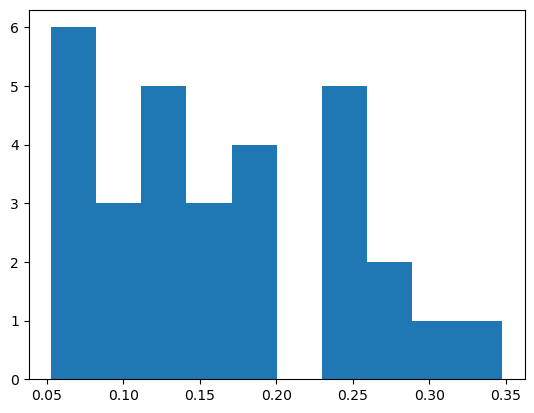

In [14]:
plt.hist(n_f/np.linalg.norm(n_f))

In [15]:
v[:,0]

array([0.07537179+0.j, 0.0693172 +0.j, 0.20456723+0.j, 0.14984061+0.j,
       0.23814258+0.j, 0.09214207+0.j, 0.05395761+0.j, 0.24414434+0.j,
       0.2593653 +0.j, 0.06096335+0.j, 0.19330407+0.j, 0.07146431+0.j,
       0.13664338+0.j, 0.11264891+0.j, 0.25685838+0.j, 0.13881139+0.j,
       0.31509832+0.j, 0.27409527+0.j, 0.17980701+0.j, 0.27445329+0.j,
       0.10300949+0.j, 0.10993423+0.j, 0.11649335+0.j, 0.08042512+0.j,
       0.19110421+0.j, 0.26666882+0.j, 0.12465139+0.j, 0.19897122+0.j,
       0.24135459+0.j, 0.14700152+0.j])

In [16]:
current_dlambda

4.0156180093348635

In [17]:
u_i_0 = np.zeros(l)
n_0 = n_f
df = np.zeros(d) 
df[0] = 2
k_p = 0
k_i = 0
g = np.zeros((d,l))
s = np.zeros((l,d))
t_f = 100
n_eval, u_i_eval, t_eval = sim_dyn_controlled(n_0,u_i_0,t_f,df,K,k,k_p,k_i,g,s,lam,n_f,d,l)

In [18]:
n_eval.shape

(30, 1000)

/var/folders/yg/rz5s_kp914g5hjl723fncj_80000gn/T/ipykernel_95507/3320174147.py:2: RuntimeWarning: invalid value encountered in divide
  dn_norm = dn/np.sqrt(np.sum(dn**2,axis = 0))


(0.0, 100.0)

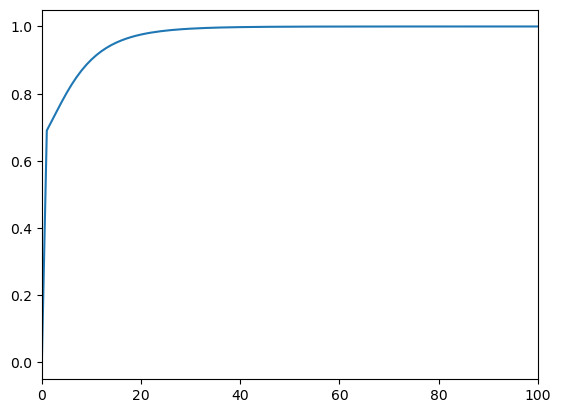

In [19]:
dn = n_eval-n_f[:, np.newaxis]
dn_norm = dn/np.sqrt(np.sum(dn**2,axis = 0))
dn_norm[:,0] = 0
plt.plot([np.dot(dn_norm[:,i],dn_norm[:,-1]) for i in range(dn_norm.shape[1])])
#for i in range(0,30):
    #plt.plot((n_eval[i,:]-n_f[i])- n_f_v, color = 'b')
#for i in range(0,30):
    #plt.plot((n_eval[i,:]-n_f[i])- n_f_v, color = 'r')  

plt.xlim([0,100])

In [20]:
dn_norm.shape

(30, 1000)

In [21]:
g = ((n_eval[:,-1]-n_f)/np.linalg.norm(n_eval[:,-1]-n_f)).reshape(-1, 1)
s = ((n_eval[:,-1]-n_f)/np.linalg.norm(n_eval[:,-1]-n_f)).reshape(1, -1)

In [22]:
s.shape

(1, 30)

In [23]:
g = (df*n_f)/np.linalg.norm(df*n_f)
s = (n_eval[:,-1]-n_f)/np.linalg.norm(n_eval[:,-1]-n_f)

In [24]:
g = (df*n_f)/np.linalg.norm(df*n_f)
s = (df*n_f)/np.linalg.norm(df*n_f)

In [25]:
df*n_f

array([0.0349322, 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ])

In [26]:
g = np.array(v)

In [27]:
c_pairs = []
for i in range(g.shape[0]):
    if np.imag(w_c[i]) != 0:
        c_pairs.append(i)
print(c_pairs)
c_pairs = c_pairs[::2]


[3, 4, 5, 6, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 25, 26, 28, 29]


In [28]:
for i in c_pairs:
    v1 = np.array(g[:,i])
    v2 = np.array(g[:,i+1])
    g[:,i] = (v1 + v2)/np.sqrt(2)
    g[:,i+1] = (v1 - v2)/np.sqrt(2)

In [29]:
s = g.T


In [30]:
j = 25

In [31]:
g = np.zeros((30,30))
g[j,j] = 1
s = np.zeros((30,30))
s[j,j] = 1

In [32]:
l = g.shape[0]
u_i_0 = np.zeros(l)
n_0 = n_f
df = np.zeros(d) 
df[25] = 2
k_p =1
k_i = 1
t_f = 100
n_eval, u_i_eval, t_eval = sim_dyn_controlled(n_0,u_i_0,t_f,df,K,k,k_p,k_i,g,s,lam,n_f,d,l)

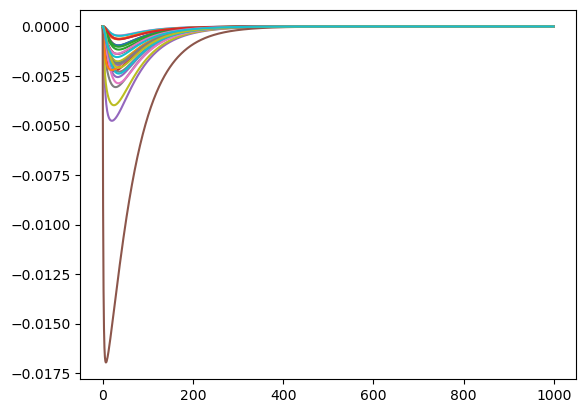

In [33]:
for i in range(0,30):
    plt.plot(n_eval[i,:]-n_f[i])

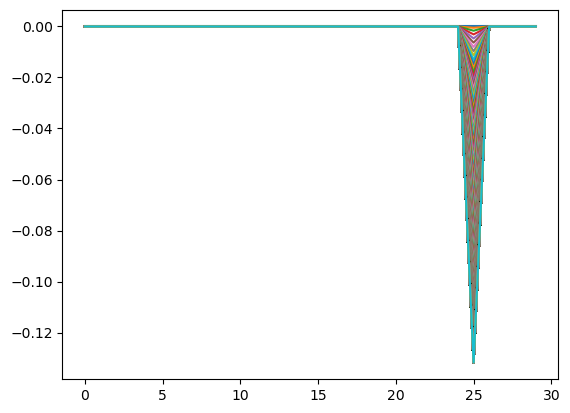

In [34]:
plt.plot(u_i_eval)

In [35]:
normal_K = np.array(current_K)
normal_k = np.array(current_k)


NameError: name 'current_K' is not defined

In [ ]:
ks = load_3d_matrix_from_csv("../many_ks.csv")
Ks = load_3d_matrix_from_csv("../many_KKs.csv")
d = Ks[0].shape[1]
lam = 5
lam = np.zeros(d)+lam
t_f = 10000

i = 0
k = ks[i]
K = Ks[i]

#initialize fixed point
n_0 = np.zeros(d) + 0.5
n_eval, u_i_eval, t_eval = sim_dyn_controlled(n_0,np.zeros(l),t_f,np.zeros(d),K,k,0,0,np.zeros((d,l)),np.zeros((l,d)),lam,n_0,d,l)
n_f = n_eval[:,-1]

#find modes
J = calc_J(k,K,n_f,lam)
w_c, v = np.linalg.eig(J)
w = np.real(w_c)

current_dlambda = np.sort(w)[-2]/np.sort(w)[-1]

lambdas = []
costs = []
is_connected = k != 0

temperature = .01
cooling_rate = .9999
l = 1
d = 30
m = 5
k_p =1
k_i = 1



In [36]:
l = 31
current_g = np.identity(l)
current_g /= np.linalg.norm(current_g,axis = 0)[np.newaxis,:]
current_s = np.identity(l)
current_s /= np.linalg.norm(current_s,axis = 1)[:, np.newaxis]
current_k = np.array(k)
current_K = np.array(K)
current_cost = evaluate_fitness_controlled_norm(K,k,k_p,k_i,current_g,current_s,lam,n_f,d,l,m,t_f)

NameError: name 'm' is not defined

In [37]:
np.log(-current_cost)

NameError: name 'current_cost' is not defined

In [38]:
l

31

In [39]:
current_g = np.ones((d,l))
current_g[:,0] = v[:,0]
current_g /= np.linalg.norm(current_g,axis = 0)[np.newaxis,:]
current_s = np.ones((l,d))
current_s[0,:] = v[:,0]
current_s /= np.linalg.norm(current_s,axis = 1)[:, np.newaxis]
current_k = np.array(k)
current_K = np.array(K)
current_cost = evaluate_fitness_controlled_norm(K,k,k_p,k_i,current_g,current_s,lam,n_f,d,l,m,t_f)

/var/folders/yg/rz5s_kp914g5hjl723fncj_80000gn/T/ipykernel_95507/651789240.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  current_g[:,0] = v[:,0]
/var/folders/yg/rz5s_kp914g5hjl723fncj_80000gn/T/ipykernel_95507/651789240.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  current_s[0,:] = v[:,0]


NameError: name 'm' is not defined

In [40]:
complex_list = []
for i in range(0,29):
    print(str(i),str(i+1))
    print(np.real(v[:,i]) - np.real(v[:,i+1]))
    if np.sum(np.real(v[:,i]) - np.real(v[:,i+1])) == 0:
        complex_list.append(i)

0 1
[ 0.04368551  0.21547413  0.18873547  0.07629455  0.32419358  0.06474561
  0.02125707  0.21372612  0.09143618  0.10457425 -0.02694938  0.08914668
 -0.02525468  0.2126437   0.86078475  0.0325035   0.30850101  0.05312986
  0.03714014  0.48475197  0.26118402  0.07241234  0.55636036 -0.03854005
 -0.03445341  0.23801903  0.14623452  0.03397454  0.06853172  0.02912912]
1 2
[-0.00582251 -0.04636707  0.11676371  0.11514151 -0.31345561  0.0414763
  0.05960748 -0.11302288  0.17516354 -0.00747281  0.32430697  0.07443506
  0.25391119 -0.20481431  0.05602691  0.04530862 -0.02787044  0.3895665
  0.23118554 -0.55649823 -0.35640268  0.11568109 -0.83602803  0.05384329
  0.25974366  0.025864    0.04692581  0.11820035 -0.0304429   0.01368585]
2 3
[-0.01324312 -0.18088197 -0.16309132  0.12213199  0.62748446  0.01960628
 -0.08939898  0.20946532  0.01896791 -0.10982585 -0.21746538 -0.09315747
 -0.08279893  0.01365428 -0.80759731  0.08107774 -0.05051458 -0.34888091
 -0.0220434   0.18259822  0.23362813  0

In [41]:
d = 30
current_g = np.array(v)
for i in complex_list:
    current_g[:,i] = np.real(current_g[:,i])
    current_g[:,i+1] = np.imag(current_g[:,i+1])
current_s = np.array(current_g).T
current_s = current_s/np.linalg.norm(current_s,axis = 1)[:,None]
current_g = current_g/np.linalg.norm(current_g,axis =0)[:,None]

In [42]:
current_g = np.ones((d,l))
current_g = v
current_g /= np.linalg.norm(current_g,axis = 0)[np.newaxis,:]
current_s = np.ones((l,d))
current_s = v.transpose()
current_s /= np.linalg.norm(current_s,axis = 1)[:, np.newaxis]
current_k = np.array(k)
current_K = np.array(K)
current_cost = evaluate_fitness_controlled_norm(K,k,k_p,k_i,current_g,current_s,lam,n_f,d,l,m,t_f)

NameError: name 'm' is not defined

In [536]:
current_cost

0.3637669810319326

In [131]:
current_cost

0.07376883400403424

In [145]:
current_dlambda

4.015618009334871

In [28]:
l

1

In [43]:
current_g = np.ones((d,l))
current_g /= np.linalg.norm(current_g,axis = 0)[np.newaxis,:]
current_s = np.ones((l,d))
current_s /= np.linalg.norm(current_s,axis = 1)[:, np.newaxis]
current_k = np.array(k)
current_K = np.array(K)



In [44]:
best_k = np.array(current_k)
best_K = np.array(current_K)
current_cost = evaluate_fitness_controlled_norm(K,k,k_p,k_i,current_g,current_s,lam,n_f,d,l,m,t_f)
best_cost = np.array(current_cost)
best_g = np.array(current_g)
best_s = np.array(current_s)

NameError: name 'm' is not defined

In [45]:
current_dlambda

4.0156180093348635

In [46]:
evaluate_fitness_controlled_norm(K,k,k_p,k_i,current_g,current_s,lam,n_f,d,l,m,t_f)

NameError: name 'm' is not defined

In [30]:

for kk in tqdm(range(6000)):
    
    lambdas.append(current_dlambda)
    costs.append(current_cost)
    if kk%2 == 0:
        idx = np.random.randint(len(np.nonzero(is_connected)[0]))
        i, j = np.nonzero(is_connected)[0][idx],np.nonzero(is_connected)[1][idx]
        k_new = np.array(current_k)
        K_new = np.array(current_K)
        K_new[i,j] = K_new[i,j] + (np.random.rand() - 0.5)*2/5
        k_new[i,j] = k_new[i,j] + (np.random.rand() - 0.5)*2/5
        
        if k_new[i,j] < 1 and K_new[i,j] < 1 and K_new[i,j] > 0 and k_new[i,j]> 0:
            
            #n0 = np.zeros(d) + 0.5
            #nt = simulate_dynamics(k_new,K_new,lam,n0)
            #n_f_new = nt[:,-1]
            n_0 = np.zeros(d) + 0.5
            n_eval, u_i_eval, t_eval = sim_dyn_controlled(n_0,np.zeros(l),t_f,np.zeros(d),K_new,k_new,0,0,np.zeros((d,l)),np.zeros((l,d)),lam,n_0,d,l)
            n_f_new = n_eval[:,-1]
            
            J = calc_J(k_new,K_new,n_f_new,lam)
            w, v = np.linalg.eig(J)
            w = np.real(w)
            
            dlambda_new = np.sort(w)[-2]/np.sort(w)[-1]
            IPR_new = calc_IPR(w,v)
            new_cost = evaluate_fitness_controlled_norm(K_new,k_new,k_p,k_i,current_g,current_s,lam,n_f_new,d,l,m,t_f)
            
            if IPR_new < 2/d and np.sort(w)[-1] < 0 and np.sum(n_f_new) > .2:
                if (new_cost < current_cost):
                    current_k = np.array(k_new)
                    current_K = np.array(K_new)
                    current_dlambda = dlambda_new
                    current_cost = new_cost
                    current_n_f = n_f_new
                    if new_cost < best_cost:
                        best_k = np.array(k_new)
                        best_K = np.array(K_new)
                        best_n_f = np.array(n_f_new)
                        best_cost = float(new_cost)
                        
                else:
                    probability = np.exp((current_cost - new_cost) / temperature)
                    if np.random.random() < probability:
                        current_k = np.array(k_new)
                        current_K = np.array(K_new)
                        current_dlambda = dlambda_new
                        current_n_f = n_f_new
                        current_cost = new_cost
    else:
        i_s, j_s = np.random.randint(current_s.shape[0]),np.random.randint(current_s.shape[1])
        i_g, j_g = np.random.randint(current_g.shape[0]),np.random.randint(current_g.shape[1])
        new_s = np.array(current_s)
        new_s[i_s,j_s] = new_s[i_s,j_s] + np.random.normal(0, 0.2)
        new_g = np.array(current_g)
        new_g[i_g, j_g] = new_g[i_g, j_g] + np.random.normal(0,0.2)
    
    
            # Ensure the Euclidean norm of new_params2 is 1
        new_s /= np.linalg.norm(new_s,axis = 1)[:, np.newaxis]
        new_g /= np.linalg.norm(new_g,axis = 0)[np.newaxis,:]
        new_cost = evaluate_fitness_controlled_norm(current_K,current_k,k_p,k_i,new_g,new_s,lam,current_n_f,d,l,m,t_f)

        if new_cost < current_cost:
            current_s = np.array(new_s)
            current_g = np.array(new_g)
            current_cost = new_cost

            if new_cost < best_cost:
                best_s = np.array(new_s)
                best_g = np.array(new_g)
                best_cost = new_cost
        else:
            probability = np.exp((current_cost - new_cost) / temperature)
            if np.random.random() < probability:
                current_s = new_s
                current_g = new_g
                current_cost = new_cost
    temperature *= cooling_rate

 46%|██████████████████                     | 2776/6000 [05:38<06:33,  8.19it/s]


KeyboardInterrupt: 

In [66]:
current_g.shape

(30, 1)

In [67]:
evaluate_fitness_controlled_norm(current_K,current_k,k_p,k_i,v[:,0].reshape(-1, 1),v[:,0].T.reshape(-1, 1),lam,current_n_f,d,l,m,t_f)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 30 is different from 1)

In [503]:
fitnesses_slow_mode_control = []
fitnesses_slow_mode_no_control = []
for ttt in tqdm(range(10000)):
    idx = np.random.randint(len(np.nonzero(is_connected)[0]))
    i, j = np.nonzero(is_connected)[0][idx],np.nonzero(is_connected)[1][idx]
    k_new = np.array(current_k)
    K_new = np.array(current_K)
    K_new[i,j] = K_new[i,j] + (np.random.rand() - 0.5)
    nt, u_i, t = sim_dyn_controlled(current_n_f,np.zeros(l),t_f,np.zeros(d),K_new,k_new,k_p,k_i,current_g,current_s,lam,current_n_f,d,l)
    fitnesses_slow_mode_control.append(n_f_dist(current_n_f,nt[:,-1]))
    nt, u_i, t = sim_dyn_controlled(current_n_f,np.zeros(l),t_f,np.zeros(d),K_new,k_new,k_p,k_i,np.zeros(current_g.shape),np.zeros(current_s.shape),lam,current_n_f,d,l)
    fitnesses_slow_mode_no_control.append(n_f_dist(current_n_f,nt[:,-1]))
                                

100%|█████████████████████████████████████| 10000/10000 [02:38<00:00, 62.98it/s]


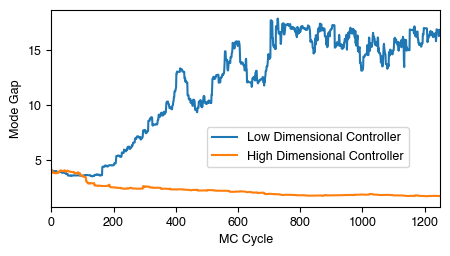

In [577]:
#plt.plot(costs)
mm_to_inches = 1/25.4  # 1 inch = 25.4 mm
width_in = 1.5*85 * mm_to_inches  # 85mm in inches
height_in = 65 * mm_to_inches  # 65mm in inches
plt.figure(figsize=(width_in, height_in))
plt.plot(lambdas_slow_mode,label='Low Dimensional Controller')
plt.plot(lambdas,label='High Dimensional Controller')

plt.legend(loc=(0.4, 0.2))
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica']
plt.rcParams.update({'font.size': 9})  # Base font size
plt.rcParams['axes.titlesize'] = 9     # Title font size
plt.rcParams['axes.labelsize'] = 9     # Axis label size
plt.rcParams['xtick.labelsize'] = 9    # X-axis tick labels
plt.rcParams['ytick.labelsize'] = 9    # Y-axis tick labels
plt.rcParams['legend.fontsize'] = 9    # Legend font size
plt.xlim([0,1250])
plt.xlabel('MC Cycle')
plt.ylabel('Mode Gap')
plt.savefig('mode_plot.svg', format='svg', dpi=300, bbox_inches='tight')

#plt.yscale('log')
#plt.xscale('log')

In [532]:
k_slow_mode = #current_k
K_slow_mode = #current_K
n_f_slow_mode = #current_n_f
costs_slow_mode = #costs
lambdas_slow_mode = l#ambdas

In [533]:
np.savetxt('k_slow_mode.csv', k_slow_mode, delimiter=',')
np.savetxt('cap_k_slow_mode.csv', K_slow_mode, delimiter=',')
np.savetxt('n_f_slow_mode.csv', n_f_slow_mode, delimiter=',')
np.savetxt('costs_slow_mode.csv', costs_slow_mode, delimiter=',')
np.savetxt('lambdas_slow_mode.csv', lambdas_slow_mode, delimiter=',')


In [444]:
n_0 = np.zeros(d) + 0.5
n_eval, u_i_eval, t_eval = sim_dyn_controlled(n_0,np.zeros(l),t_f,np.zeros(d),current_K,current_k,0,0,np.zeros((d,l)),np.zeros((l,d)),lam,n_0,d,l)
n_f_dist(n_f_current,n_eval[:,-1])

NameError: name 'n_f_current' is not defined

In [429]:
np.sum(current_n_f)

0.20263144724247273

In [469]:
n_0 = np.zeros(d) + 0.5
n_eval, u_i_eval, t_eval = sim_dyn_controlled(current_n_f,np.zeros(l),t_f,df,current_K,current_k,0,0,np.zeros((d,l)),np.zeros((l,d)),lam,n_0,d,l)
n_f_dist(current_n_f,n_eval[:,-1])

0.0055830374957330535

In [455]:
df

array([2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [448]:
n_eval[:,-1]

array([0.00255303, 0.00300824, 0.00713486, 0.00568369, 0.01136974,
       0.0073758 , 0.00281033, 0.00680083, 0.00824383, 0.00408303,
       0.00483691, 0.00459192, 0.00376407, 0.00566362, 0.00691224,
       0.00525209, 0.01038239, 0.00993948, 0.00666402, 0.01475641,
       0.00307342, 0.00305579, 0.00411405, 0.00240721, 0.00704829,
       0.01113995, 0.00534966, 0.00406817, 0.00719986, 0.0045889 ])

In [344]:
n_eval[:,-1]

array([1.08041437e-19, 1.07468026e-19, 3.99570650e-19, 1.61422797e-19,
       1.18450477e-18, 2.00507214e-19, 2.39257942e-19, 4.79388265e-19,
       6.16419971e-19, 1.48497441e-19, 4.14573861e-19, 2.42913523e-19,
       2.01131661e-19, 2.43426904e-19, 1.24320170e-18, 3.49730657e-19,
       9.21402078e-19, 4.66424868e-19, 4.49329256e-19, 1.30514307e-18,
       5.16068688e-19, 3.17080475e-19, 4.75129437e-19, 1.18046358e-19,
       4.67951674e-19, 5.89227842e-19, 5.17270493e-19, 3.58155141e-19,
       4.36275169e-19, 2.92976832e-19])

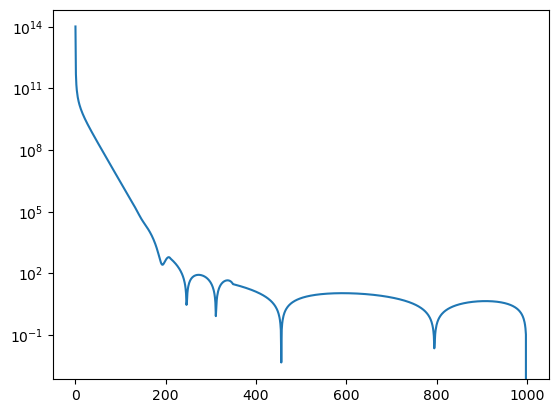

In [329]:
plt.plot([n_f_dist(current_n_f,n_eval[:,i]) for i in range(n_eval.shape[1])] )
plt.yscale('log')

In [277]:
n_eval[:,-1]

array([1.43406956e-06, 3.15536846e-06, 4.57213073e-06, 3.81212534e-06,
       7.16717066e-06, 2.67207762e-06, 6.37034318e-07, 6.55961445e-06,
       7.04606997e-06, 2.79481576e-06, 4.55084877e-06, 2.32351471e-06,
       2.27973345e-06, 4.16206653e-06, 1.20581676e-05, 3.23553348e-06,
       5.82607602e-06, 7.68400744e-06, 4.14919672e-06, 4.96480290e-06,
       4.33354206e-06, 2.05289794e-06, 7.21613925e-06, 1.34200069e-06,
       4.28923731e-06, 6.93608099e-06, 4.07037894e-06, 4.21115239e-06,
       6.23347569e-06, 3.06770539e-06])

In [471]:
n_0 = np.zeros(d) + 0.5
n_eval, u_i_eval, t_eval = sim_dyn_controlled(current_n_f,np.zeros(l),t_f,df,current_K,current_k,k_p,k_i,current_g,current_s,lam,current_n_f,d,l)
n_f_dist(current_n_f,n_eval[:,-1])

0.0014007164691489246

In [ ]:
n_0 = np.zeros(d) + 0.5
n_eval, u_i_eval, t_eval = sim_dyn_controlled(n_0,np.zeros(l),t_f,np.zeros(d),K_new,k_new,0,0,np.zeros((d,l)),np.zeros((l,d)),lam,n_0,d,l)
n_f_new = n_eval[:,-1]

In [273]:
n_eval[:,-1]

array([ 8.59271498e+32,  8.59271498e+32, -5.81796012e+33,  8.59271498e+32,
        8.59271498e+32,  8.59271498e+32,  8.59271498e+32,  8.59271498e+32,
        8.59271498e+32, -5.91882068e+48,  8.59271498e+32,  8.59271498e+32,
        8.59271498e+32, -3.90975358e+35,  8.59271498e+32,  8.59271498e+32,
       -4.36883493e+34, -4.21094579e+34,  8.59271498e+32,  8.59271498e+32,
        8.59271498e+32, -1.22751053e+33,  8.59271498e+32,  8.59271498e+32,
        8.59271498e+32,  8.59271498e+32,  8.59271498e+32,  8.59271498e+32,
        8.59271498e+32,  8.59271498e+32])

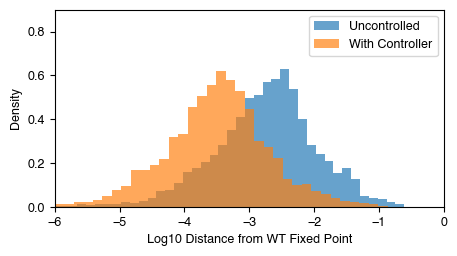

In [529]:
mask1 = np.array(fitnesses_slow_mode_no_control) < 1
mask2 = np.array(fitnesses_slow_mode_control) < 1
mm_to_inches = 1/25.4  # 1 inch = 25.4 mm
width_in = 1.5*85 * mm_to_inches  # 85mm in inches
height_in = 65 * mm_to_inches  # 65mm in inches
plt.figure(figsize=(width_in, height_in))
plt.hist(np.log10(np.array(fitnesses_slow_mode_no_control)[mask1 & mask2]),alpha = 0.68,bins=50,density = True,label = 'Uncontrolled')
plt.hist(np.log10(np.array(fitnesses_slow_mode_control)[mask1 & mask2]),alpha = 0.68,bins=50,density = True,label='With Controller')
plt.legend()
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica']
plt.rcParams.update({'font.size': 9})  # Base font size
plt.rcParams['axes.titlesize'] = 9     # Title font size
plt.rcParams['axes.labelsize'] = 9     # Axis label size
plt.rcParams['xtick.labelsize'] = 9    # X-axis tick labels
plt.rcParams['ytick.labelsize'] = 9    # Y-axis tick labels
plt.rcParams['legend.fontsize'] = 9    # Legend font size
plt.xlabel('Log10 Distance from WT Fixed Point')
plt.ylabel('Density')

plt.xlim([-6,0])
plt.ylim([0,.9])
plt.savefig('plot.svg', format='svg', dpi=300, bbox_inches='tight')

(array([997.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   1.]),
 array([-14.68153278,  -1.66472345,  11.35208588,  24.36889522,
         37.38570455,  50.40251388,  63.41932321,  76.43613255,
         89.45294188, 102.46975121, 115.48656054]),
 <BarContainer object of 10 artists>)

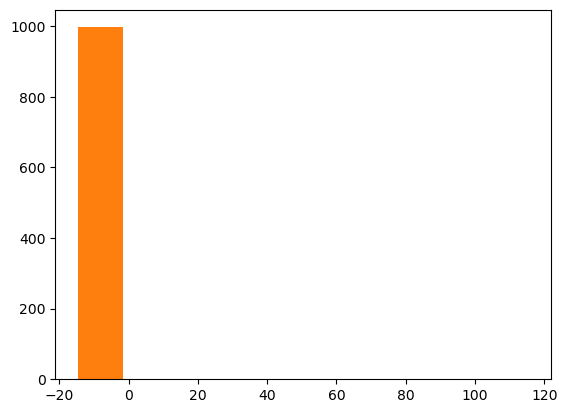

In [496]:
plt.hist(np.log(np.array(fitnesses_slow_mode_no_control)[mask]))
plt.hist(np.log(np.array(fitnesses_slow_mode_control)[mask]))

In [480]:
fitnesses_slow_mode_no_control

[0.0001787669075440082,
 0.005539726764954643,
 0.026927474171117745,
 0.0007969489586866415,
 0.0017763773350110634,
 0.0018337281633498124,
 0.0013227044768799902,
 0.006975127216467085,
 0.0005260637598229739,
 0.0010061255305388239,
 0.002923016979592819,
 0.0009624590326614864,
 0.0016634677940563156,
 0.0017165800479813807,
 0.003642659609583391,
 0.00270703839586832,
 0.0009620461016225442,
 0.04692155779930723,
 4.816219121600052e-06,
 0.0013536485988878896,
 0.0019378840656755698,
 0.0013349915278570556,
 0.0017320034917234603,
 0.013444322568540388,
 0.0011027981571134573,
 0.0019524666953971493,
 0.00037225789310023263,
 0.004136939352640634,
 0.0011981227225857738,
 0.0012258883483479408,
 0.0009573468046797739,
 0.008017326014251189,
 0.0008670732668248823,
 0.0013759563026220685,
 0.0002542816184225013,
 0.008831182559565862,
 0.0027144402086761344,
 0.0006650373399557832,
 0.00369698996539453,
 0.0013104595022701152,
 0.0012440988575078845,
 0.002333494604222364,
 0.0107

In [176]:
lambdas[-1]

38.071773952276224

In [242]:
costs[-1]

0.04679284118043042

In [140]:
lambdas[-1]

64.81736420981818

/var/folders/yg/rz5s_kp914g5hjl723fncj_80000gn/T/ipykernel_58773/551269757.py:10: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim((0,100))


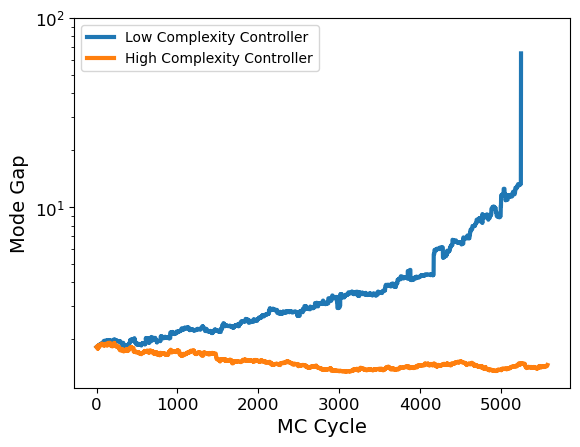

In [123]:
#plt.plot(lambdas_lowd[0:503])
plt.plot(lambdas_lowd,label = 'Low Complexity Controller',linewidth=3.0)
plt.plot(lambdas,label = 'High Complexity Controller',linewidth=3.0)
plt.ylabel('Mode Gap', fontsize=14)
plt.xlabel('MC Cycle', fontsize=14)
plt.legend()
plt.yscale('log')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.ylim((0,100))
plt.savefig('int_feedback_mc.png',dpi = 500)

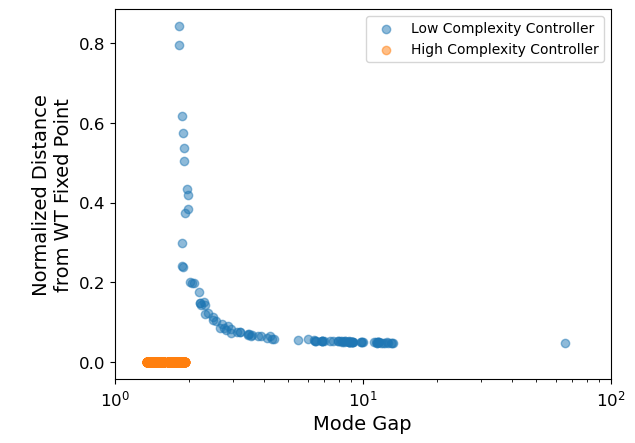

In [111]:
plt.scatter(lambdas_lowd[0:100:15],costs_lowd[0:100:15],alpha = 0.5,color = "tab:blue",label = 'Low Complexity Controller')
plt.scatter(lambdas_lowd[100:4500:100],costs_lowd[100:4500:100],alpha = 0.5,color = "tab:blue")
plt.scatter(lambdas_lowd[4500::15],costs_lowd[4500::15],alpha = 0.5,color = "tab:blue")
plt.scatter(lambdas_lowd[-1],costs_lowd[-1],alpha = 0.5,color = "tab:blue")
plt.xscale('log')
#plt.scatter(lambdas_lowd[0:5000],costs_lowd[0:5000])
plt.xlim((1,100))
plt.scatter(lambdas,costs,alpha = 0.5,color = "tab:orange",label = 'High Complexity Controller')
plt.xlabel('Mode Gap', fontsize=14)
plt.ylabel('\n Normalized Distance \nfrom WT Fixed Point', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend()
plt.savefig('int_feedback_tradeoff.png',dpi = 500)
plt.show()


In [185]:
evaluate_fitness_controlled_norm(K,k,k_p,k_i,current_g,current_s,lam,n_f,d,l,m,t_f)

0.5153004954085901

In [35]:
#lambdas_lowd = np.array(lambdas)
#costs_lowd = np.array(costs)

In [172]:
lambdas_30d = np.array(lambdas)
costs_30d = np.array(costs)

In [ ]:


for kk in tqdm(range(2000)):
    
    lambdas.append(current_dlambda)
    costs.append(current_cost)
    if kk%1 == 0:
        l = np.random.randint(len(np.nonzero(is_connected)[0]))
        i, j = np.nonzero(is_connected)[0][l],np.nonzero(is_connected)[1][l]
        k_new = np.array(current_k)
        K_new = np.array(current_K)
        K_new[i,j] = K_new[i,j] + (np.random.rand() - 0.5)*2/5
        k_new[i,j] = k_new[i,j] + (np.random.rand() - 0.5)*2/5
        
        if k_new[i,j] < 1 and K_new[i,j] < 1 and K_new[i,j] > 0 and k_new[i,j]> 0:
            
            n0 = np.zeros(g) + 0.5
            nt = simulate_dynamics(k_new,K_new,lam,n0)
            n_f_new = nt[:,-1]
            
            J = calc_J(k_new,K_new,n_f_new,lam)
            w, v = np.linalg.eig(J)
            w = np.real(w)
            
            dlambda_new = np.sort(w)[-2]/np.sort(w)[-1]
            IPR_new = calc_IPR(w,v)
            new_cost = evaluate_fitness_controlled_norm(k_new,K_new,n_f_new,lam,scale*current_lam_c,current_s_hat,m,t_f,g)
            
            if (IPR_new < 2/g) and (np.sort(w)[-1] < 0):
                if (new_cost < current_cost):
                    current_k = np.array(k_new)
                    current_K = np.array(K_new)
                    current_dlambda = dlambda_new
                    current_cost = new_cost
                    current_n_f = n_f_new
                    if new_cost < best_cost:
                        best_k = np.array(k_new)
                        best_K = np.array(K_new)
                        best_n_f = np.array(n_f_new)
                        best_cost = float(new_cost)
                        
                else:
                    probability = np.exp((current_cost - new_cost) / temperature)
                    if np.random.random() < probability:
                        current_k = np.array(k_new)
                        current_K = np.array(K_new)
                        current_dlambda = dlambda_new
                        current_n_f = n_f_new
                        current_cost = new_cost
    else:
        i_s, j_s = np.random.randint(current_s_hat.shape[0]),np.random.randint(current_s_hat.shape[1])
        i_l, j_l = np.random.randint(current_lam_c.shape[0]),np.random.randint(current_lam_c.shape[1])
        new_s_hat = np.array(current_s_hat)
        new_s_hat[i_s,j_s] = new_s_hat[i_s,j_s] + np.random.normal(0, 0.2)
        new_lam_c = np.array(current_lam_c)
        new_lam_c[i_l, j_l] = new_lam_c[i_l, j_l] + np.random.normal(0,0.2)
    
    
            # Ensure the Euclidean norm of new_params2 is 1
        new_s_hat /= np.linalg.norm(new_s_hat,axis = 1)[:, np.newaxis]
        new_lam_c /= np.linalg.norm(new_lam_c,axis = 0)[np.newaxis,:]
        new_cost = evaluate_fitness_controlled(current_k,current_K,current_n_f,lam,scale*new_lam_c,new_s_hat,m,t_f,g)

        if new_cost < current_cost:
            current_s_hat = np.array(new_s_hat)
            current_lam_c = np.array(new_lam_c)
            current_cost = new_cost

            if new_cost < best_cost:
                best_s_hat = np.array(new_s_hat)
                best_lam_c = np.array(new_lam_c)
                best_cost = new_cost
        else:
            probability = np.exp((current_cost - new_cost) / temperature)
            if np.random.random() < probability:
                current_s_hat = new_s_hat
                current_lam_c = new_lam_c
                current_cost = new_cost
    temperature *= cooling_rate